In [45]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
#from keras.models import Sequential
#from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
#from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


#from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_1A_MONTHLY.csv')
zone_data_7 = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_7_MONTHLY.csv')
zone_data_6 = pd.read_csv('../[3.1] - OUTLIER_REMOVAL/zone_data_6_MONTHLY.csv')


# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A.copy()
#zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6.copy()
#zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7.copy()
#zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='date', ascending=True, inplace=True)
#zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zones = {
    'Zone 1A': zone_data_1A_top_sorted,
    'Zone 7': zone_data_7_top_sorted,
    'Zone 6': zone_data_6_top_sorted
}




In [46]:


stats_data = []


def build_arma_model(data, order):
    from statsmodels.tsa.arima.model import ARIMA
    # ARMA model is a special case of ARIMA with no differencing (d=0)
    model = ARIMA(data, order=(order[0], order[1], order[2]), enforce_stationarity=False)
    fitted_model = model.fit()
    return fitted_model

def forecast_and_simulate(model, steps=1000):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean

    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']

    return forecast_mean, conf_intervals



/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

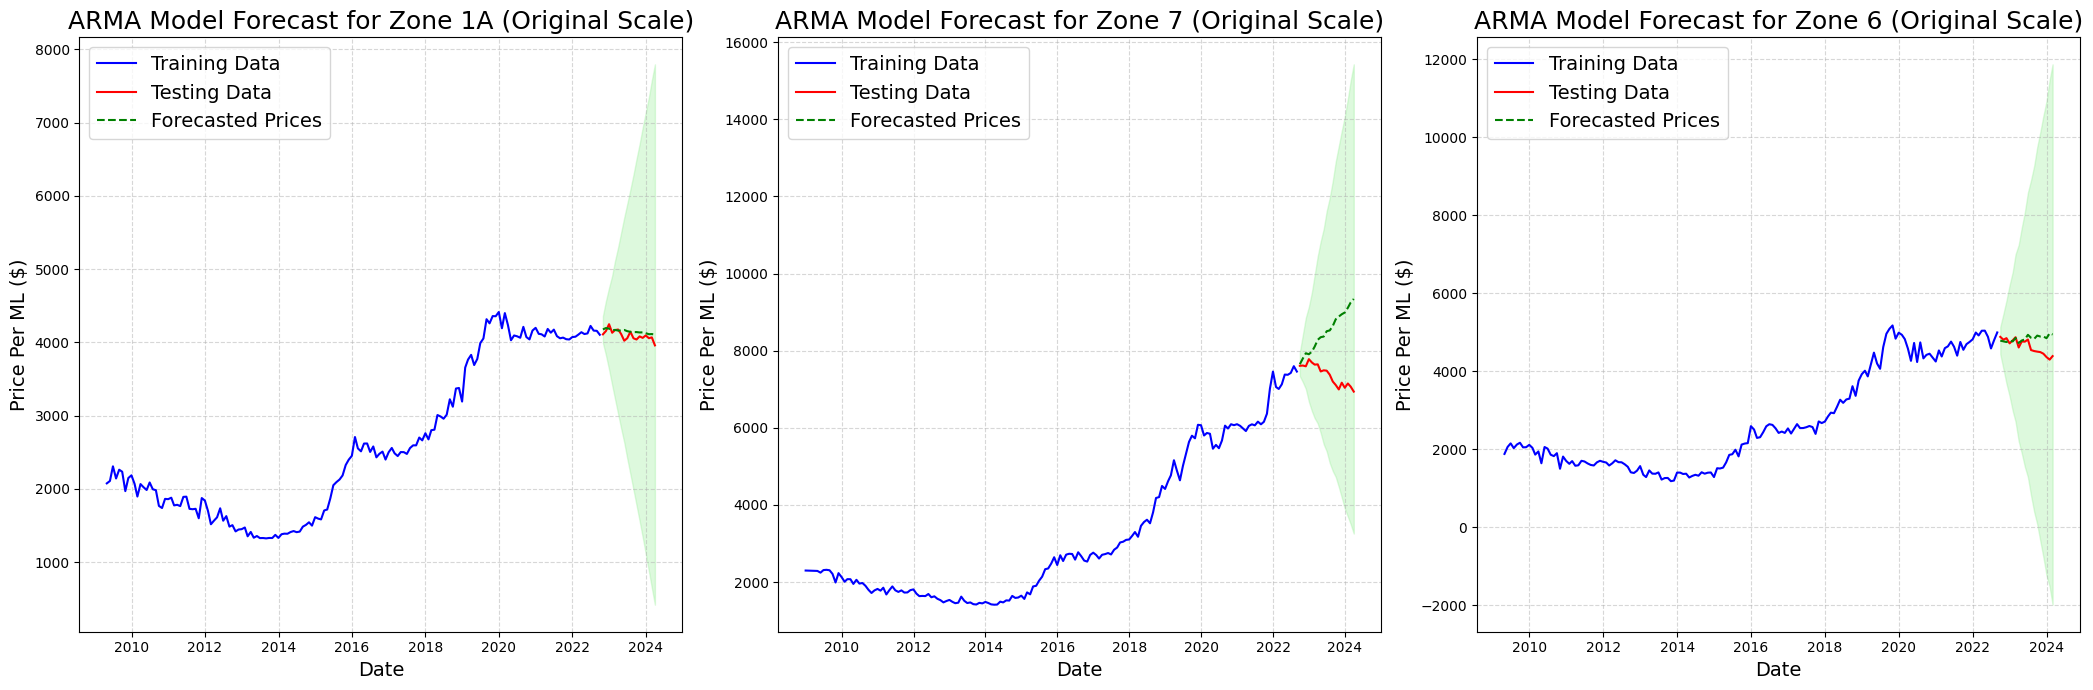

      Zone           MSE         MAE       R^2
0  Zone 1A   4134.673121   55.368150 -0.033342
1   Zone 7  32028.428839  161.936527 -1.975863
2   Zone 6  10367.589659   83.522934  0.175122
                               SARIMAX Results                                
Dep. Variable:             mean_price   No. Observations:                  161
Model:               ARIMA(10, 2, 10)   Log Likelihood                -964.861
Date:                Sun, 16 Jun 2024   AIC                           1971.723
Time:                        22:25:42   BIC                           2034.664
Sample:                    05-31-2009   HQIC                          1997.296
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9113 

In [47]:
zones = {
    'Zone 1A': zone_data_1A_top_sorted,
    'Zone 7': zone_data_7_top_sorted,
    'Zone 6': zone_data_6_top_sorted
}

stats_data = []

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))  # Adjusted for 3 columns

for i, (zone_name, zone_data) in enumerate(zones.items()):
    zone_data['date'] = pd.to_datetime(zone_data['date'])
    series_data = zone_data.set_index('date')['mean_price']
    
    # Differencing the data to make it stationary
    differenced_data = series_data.diff().dropna()
    
    train_data, test_data = train_test_split(differenced_data, test_size=0.1, shuffle=False)
    
    arma_model = build_arma_model(train_data, order=(10, 2, 10))
    forecast_series, conf_df = forecast_and_simulate(arma_model, steps=len(test_data))
    
    # Calculate statistics
    mse = mean_squared_error(test_data, forecast_series)
    mae = mean_absolute_error(test_data, forecast_series)
    r_squared = r2_score(test_data, forecast_series)
    
    stats_data.append({
        'Zone': zone_name,
        'MSE': mse,
        'MAE': mae,
        'R^2': r_squared
    })
    
    ax = axes[i]
    # Undifferencing the forecast to original scale
    forecast_series_cumulative = series_data.iloc[:len(train_data)].iloc[-1] + forecast_series.cumsum()
    test_data_cumulative = series_data.iloc[:len(train_data)].iloc[-1] + test_data.cumsum()
    
    ax.plot(series_data.index[:len(train_data)], train_data.cumsum() + series_data.iloc[0], label="Training Data", color='blue')
    ax.plot(series_data.index[len(train_data):len(train_data)+len(test_data)], test_data_cumulative, label="Testing Data", color='red')
    ax.plot(series_data.index[len(train_data):len(train_data)+len(test_data)], forecast_series_cumulative, label="Forecasted Prices", linestyle='--', color='green')
    ax.fill_between(series_data.index[len(train_data):len(train_data)+len(test_data)], conf_df['lower'].cumsum() + series_data.iloc[:len(train_data)].iloc[-1], conf_df['upper'].cumsum() + series_data.iloc[:len(train_data)].iloc[-1], alpha=0.3, color='lightgreen')
    
    ax.set_title(f"ARMA Model Forecast for {zone_name} (Original Scale)", fontsize=18)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("Price Per ML ($)", fontsize=14)
    ax.legend(loc='upper left', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Display statistics in a DataFrame
stats_df = pd.DataFrame(stats_data)
print(stats_df)
model_summary = arma_model.summary()
print(model_summary)

# SARIMAX

In [48]:
exog_data = pd.read_csv('../[3.2] - EXOG_PCA/EXOG_MONTHLY_MEDIAN_CONSOLIDATED.csv')

# Split data into train and test sets
train_data, test_data = train_test_split(series_data[2:], test_size=0.1, shuffle=False)
train_exog, test_exog = train_test_split(exog_data[2:], test_size=0.1, shuffle=False)

train_exog = train_exog.apply(pd.to_numeric, errors='coerce')

# Optionally, drop rows with NaN values if they are not significant in number
train_exog = train_exog.dropna()


In [49]:
def build_sarma_model(data, order):
    from statsmodels.tsa.arima.model import ARIMA
    # SARIMA model includes both non-seasonal and seasonal elements
    model = ARIMA(data, order=order, seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, exog=np.asarray(train_exog[2:]))
    fitted_model = model.fit()
    return fitted_model

def forecast_sarima_and_simulate(model, steps=1000):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean

    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']

    return forecast_mean, conf_intervals

ValueError: zero-size array to reduction operation maximum which has no identity

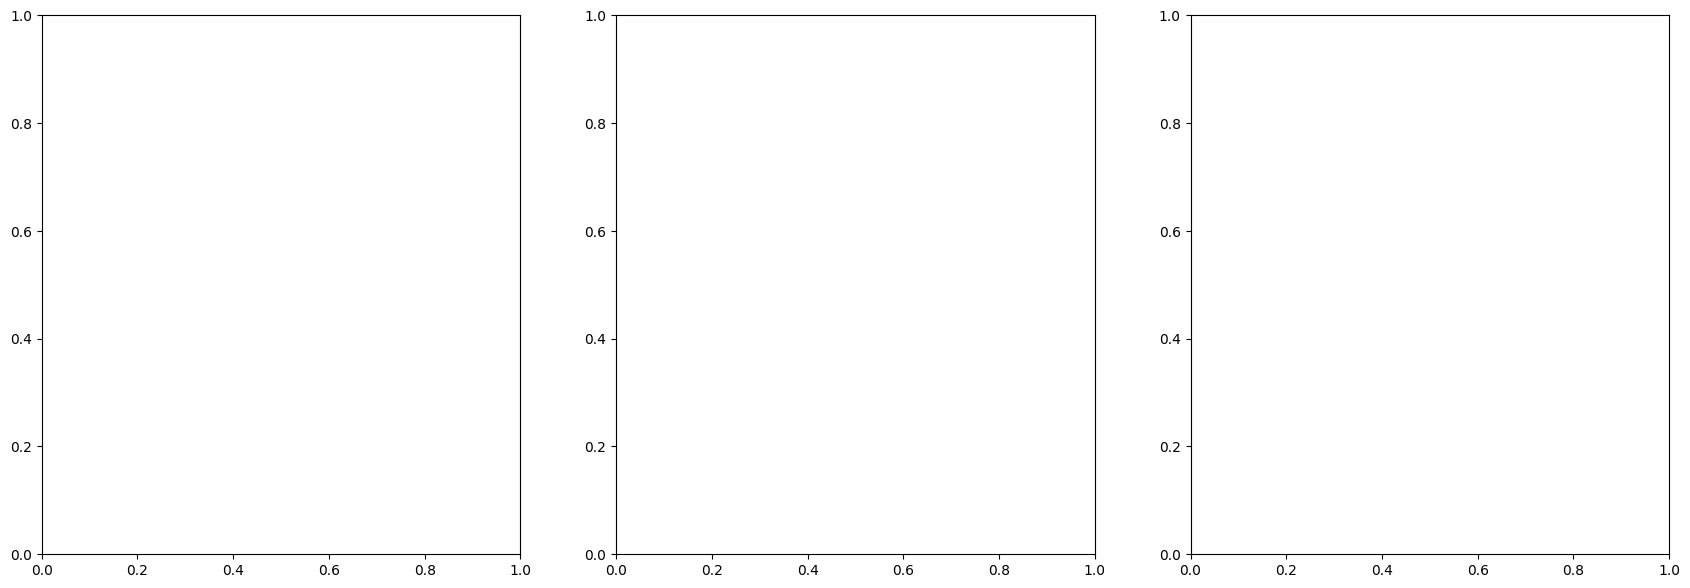

In [50]:
zones = {
    'Zone 1A': zone_data_1A_top_sorted,
    'Zone 7': zone_data_7_top_sorted,
    'Zone 6': zone_data_6_top_sorted
}

stats_data = []

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))  # Adjusted for 3 columns

for i, (zone_name, zone_data) in enumerate(zones.items()):
    zone_data['date'] = pd.to_datetime(zone_data['date'])
    series_data = zone_data.set_index('date')['mean_price']
    
    # Differencing the data to make it stationary
    differenced_data = series_data.diff().dropna()
    
    train_data, test_data = train_test_split(differenced_data, test_size=0.1, shuffle=False)
    
    # Build SARIMA model
    sarima_model = build_sarma_model(train_data, order=(10, 2, 10))
    forecast_series, conf_df = forecast_sarima_and_simulate(sarima_model, steps=len(test_data))
    
    # Calculate statistics
    mse = mean_squared_error(test_data, forecast_series)
    mae = mean_absolute_error(test_data, forecast_series)
    r_squared = r2_score(test_data, forecast_series)
    
    stats_data.append({
        'Zone': zone_name,
        'MSE': mse,
        'MAE': mae,
        'R^2': r_squared
    })
    
    ax = axes[i]
    # Undifferencing the forecast to original scale
    forecast_series_cumulative = series_data.iloc[:len(train_data)].iloc[-1] + forecast_series.cumsum()
    test_data_cumulative = series_data.iloc[:len(train_data)].iloc[-1] + test_data.cumsum()
    
    ax.plot(series_data.index[:len(train_data)], train_data.cumsum() + series_data.iloc[0], label="Training Data", color='blue')
    ax.plot(series_data.index[len(train_data):len(train_data)+len(test_data)], test_data_cumulative, label="Testing Data", color='red')
    ax.plot(series_data.index[len(train_data):len(train_data)+len(test_data)], forecast_series_cumulative, label="Forecasted Prices", linestyle='--', color='green')
    ax.fill_between(series_data.index[len(train_data):len(train_data)+len(test_data)], conf_df['lower'].cumsum() + series_data.iloc[:len(train_data)].iloc[-1], conf_df['upper'].cumsum() + series_data.iloc[:len(train_data)].iloc[-1], alpha=0.3, color='lightgreen')
    
    ax.set_title(f"SARIMA Model Forecast for {zone_name} (Original Scale)", fontsize=18)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("Price Per ML ($)", fontsize=14)
    ax.legend(loc='upper left', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Display statistics in a DataFrame
stats_df = pd.DataFrame(stats_data)
print(stats_df)
model_summary = sarima_model.summary()
print(model_summary)

# SARIMAX